# Equiripple Filters in Julia.

[JuliaCon (London)](http://juliacon.org/2018/), July 8, 2018. 

Presenter: Tom Krauss. 

Signal Processing / Software Engineer at [Epiq Solutions](http://epiqsolutions.com) (Schaumburg IL). 

PhD in Electrical Engineering (Purdue).

## FIR filter background
$y[n] = \sum_{m=0}^{L-1}h[m]x[n-m]$
![block diagram](fir_filter_block_diagram.png)
$Y(\omega) = \sum_{n=-\infty}^{\infty}y[n]e^{-jn\omega} = H(\omega)X(\omega)$

## FIR filters in Julia. Low pass filter example
$H(\omega)=1$ for $-2\pi f_c \le \omega \le 2\pi f_c$

$H(\omega)=0$ for $|\omega| \ge 2\pi f_c$


$h[n]=\frac{1}{2\pi}\int_{-\infty}^{\infty}H(\omega)e^{jn\omega}d\omega$

$= 2 f_c \text{sinc}(2 f_c n)$

In [156]:
using PyPlot

function plot_response(h, fc, nfft=2000)
    L = length(h)
    M = (L-1)÷2
    h_zero_pad = zeros(nfft)
    h_zero_pad[1:M+1] = h[end-M:end]
    h_zero_pad[end-M+1:end] = h[1:M]
    H = real.(fftshift(fft(h_zero_pad)))
    n = -M : M

    subplot(121)
    plot( n, h, ".-")
    title("Time domain")
    xlabel("n")
    grid()
    
    subplot(122)
    f = ((-nfft÷2):(nfft÷2-1))/nfft
    Hideal(f) = (abs.(collect(f)).<=fc)*1
    plot(2f, Hideal(f), label="\$H(f)\$ ideal")
    plot(2f, H, label="\$H(f)\$")
    legend(loc="best", fontsize="small")
    title("Frequency domain")
    xlabel("\$f\$")
    setp(gca(), xlim=(0,1), ylim=(-0.2, 1.2))
    grid()
end

plot_response (generic function with 2 methods)

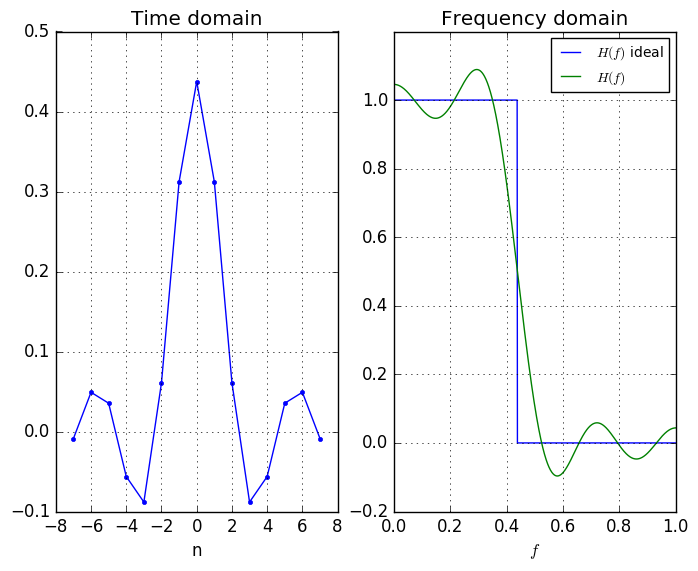

In [162]:
fc = (0.5 + 0.375)/4  # cutoff frequency
n = -7 : 7  # finite length - best L2 approximation
h = 2fc * sinc.(2fc * n)
plot_response(h, fc)  # lots of ringing

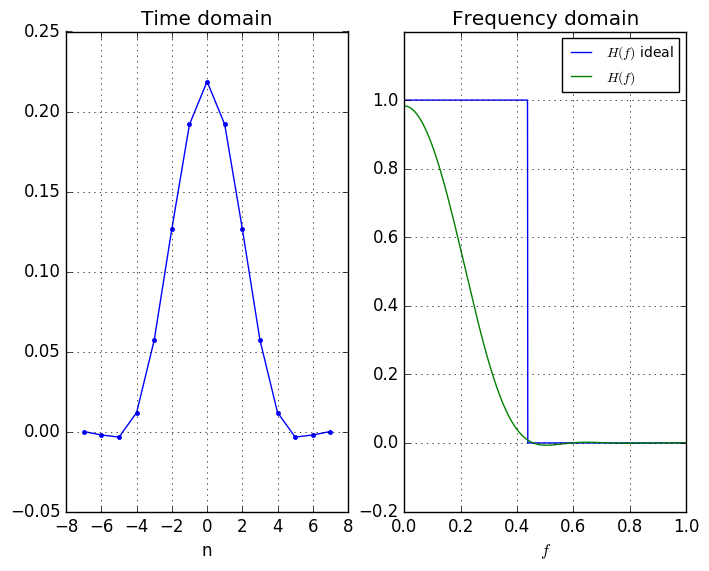

In [163]:
using DSP
ftype = Lowpass(fc)
proto = FIRWindow(hanning(15), scale=false)  # apply window to "smooth" ringing in frequency
h_window = digitalfilter(ftype, proto)
plot_response(h_window, fc) # stop band is much better, but pass band is much worse here - heuristic

# PARKS-MCCLELLAN ALGORITHM

![jim mcclellan](JMcRemezCards.png)
Jim McClellan with FORTRAN card decks.
"The date 3-3-3 is 3-March-1973 which was the final version of Remez prior to my PhD defense."


## Chebyshev approximation
Introduce a "transition" band between the passband and stopband, and minimize the maximum error.

**Alternation theorem** from Chebyshev approximation theory states that the filter is optimal if (and only if) the error alternates (positive, then negative, then positive, etc) at its maximum at least $M+2$ times (for filter length $L = 2M + 1$)

**references**
["a personal history"](https://ieeexplore.ieee.org/document/1406492/) [doug jones talk](https://cnx.org/exports/0bb211fb-4a74-4efc-8a90-291cef969b75@3.pdf/parks-mcclellan-fir-filter-design-3.pdf)

In [159]:
using PyPlot

function plot_equiripple_response(h, f1, f2, delta, nfft=2000)
    L = length(h)
    M = (L-1)÷2
    h_zero_pad = zeros(nfft)
    h_zero_pad[1:M+1] = h[end-M:end]
    h_zero_pad[end-M+1:end] = h[1:M]
    H = real.(fftshift(fft(h_zero_pad)))
    
    f = ((-nfft÷2):(nfft÷2-1))/nfft
    plot([0, f1, f1, f2, 1.0], [1, 1, NaN, 0, 0], label="\$H(f)\$ ideal")
    plot(2f, H, label="\$H(f)\$")
    plot([0, f1], [1+delta, 1+delta], "r:")
    plot([0, f1], [1-delta, 1-delta], "r:")
    plot([f2, 1], [delta, delta], "r:")
    plot([f2, 1], [-delta, -delta], "r:")
    extremals = []
    for i = 1 : length(H)
        if f[i]<=f1
            if abs(H[i]-(1+delta))<0.0001
                if !((i-1 in extremals) | (i-2 in extremals))
                    push!(extremals, i)
                end
            end
        end
        if f[i]>=f2
        end
    end
    plot(2f[extremals], H[extremals], "*")
    title("Frequency domain")
    legend(loc="best", fontsize="small")
    xlabel("\$f\$")
    setp(gca(), xlim=(0,1), ylim=(-0.2, 1.2))
    grid()
    return H
end
f1, f2 = 0.375, 0.5
h = remez(15, vec([0, f1, f2, 1.0]), vec([1.0, 0.0]); Hz=2.0);
delta = 0.088359;
delta = 0.088421;

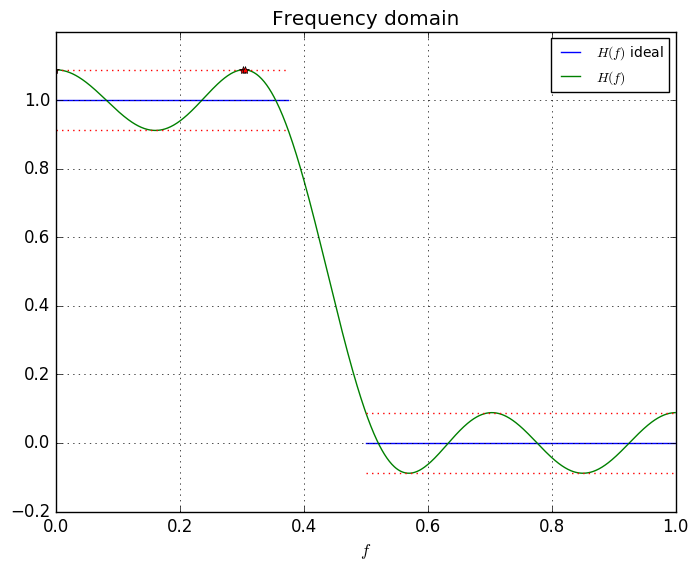

In [160]:
Hr = plot_equiripple_response(h, f1, f2, delta);
# Alternation theorem: must have M+2 = 9 "alternations" where the error is maximum.
# Tells us that this filter is optimal.
# How to design the filter?

## Parks-McClellan Algorithm

1. Start with initial, uniformly spaced set of "extremal" frequencies - guesses as to where the error is maximal. 
2. Make the error equiripple on that set - it is not maximal at first.
3. If
        
        the error is maximal on the extremal frequencies, we are done.
        
4. Else,

        change the extremal frequencies in the direction of increasing error. Go to 2.

It's like squeezing a balloon.

# REMEZ FUNCTION IN JULIA
Merged to DSP.jl package, July 2018.

Efforts by myself and other contributors - special thanks to [Martin Holters](https://github.com/martinholters) for reviews and contributions. 

[julia source](https://github.com/JuliaDSP/DSP.jl/blob/master/src/Filters/remez_fir.jl)

Translation from C to Julia.

Line-for-line, and hence functionally equivalent, with python's scipy.signal "remez" (implemented in C).

## How to call "remez" in Julia
```
using DSP
h = remez(numtaps, bands, desired; Hz=Hz)
```

For example:

```
h = remez(15, vec([0 0.375 0.5 1.0]), vec([1.0 0.0]); Hz=2.0)
```
<img src="remez_function_inputs.png" alt="remez_specs" width="600">



## Comparison with C implementation (DSPRemezWrap.jl) - run times
<img src="remez_time_julia_c_compare.png" alt="run_time_compare" width="800">


# Conclusion
Go forth and design filters - with "remez" in DSP.jl!